In [118]:
# from pandas_datareader import data
import datetime as dt
import urllib.request, json
import os
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from dotenv import load_dotenv
load_dotenv(override=True)

True

In [119]:
PATH = os.environ.get("PATH_RAW_DATA")
TICKER = os.environ.get("TICKER")
PATH_RAW_DATA = f"{PATH}-{TICKER}.json"
PATH_RAW_DATA_CSV = f"{PATH}-{TICKER}.csv"
print(f"Looking for {TICKER}")

if not os.path.exists(PATH_RAW_DATA_CSV):
  f = open(PATH_RAW_DATA)
  data = json.load(f)
  data = data['Time Series (Daily)']
  df = pd.DataFrame(columns=['Date','Low','High','Close','Open'])
  for k,v in data.items():
    date = dt.datetime.strptime(k, '%Y-%m-%d')
    data_row = [date.date(),float(v['3. low']),float(v['2. high']),
                float(v['4. close']),float(v['1. open'])]
    df.loc[-1,:] = data_row
    df.index = df.index + 1
  print('Data saved to : %s'%PATH_RAW_DATA_CSV)        
  df.to_csv(PATH_RAW_DATA_CSV)

# If the data is already there, just load it from the CSV
else:
    print('File already exists. Loading data from CSV')
    df = pd.read_csv(PATH_RAW_DATA_CSV)


Looking for COKE
File already exists. Loading data from CSV


In [120]:
# Sort DataFrame by date
df = df.sort_values('Date')

df = df.iloc[365*9:]
# Double check the result
df.head()

,Unnamed: 0,Date,Low,High,Close,Open
2320,3285,2012-11-21,64.847,65.580,65.50,65.58
2319,3286,2012-11-23,65.710,66.979,66.60,65.71
2318,3287,2012-11-26,66.340,67.910,67.69,66.34
2317,3288,2012-11-27,66.500,68.750,66.92,67.81
2316,3289,2012-11-28,66.570,67.910,67.25,66.90


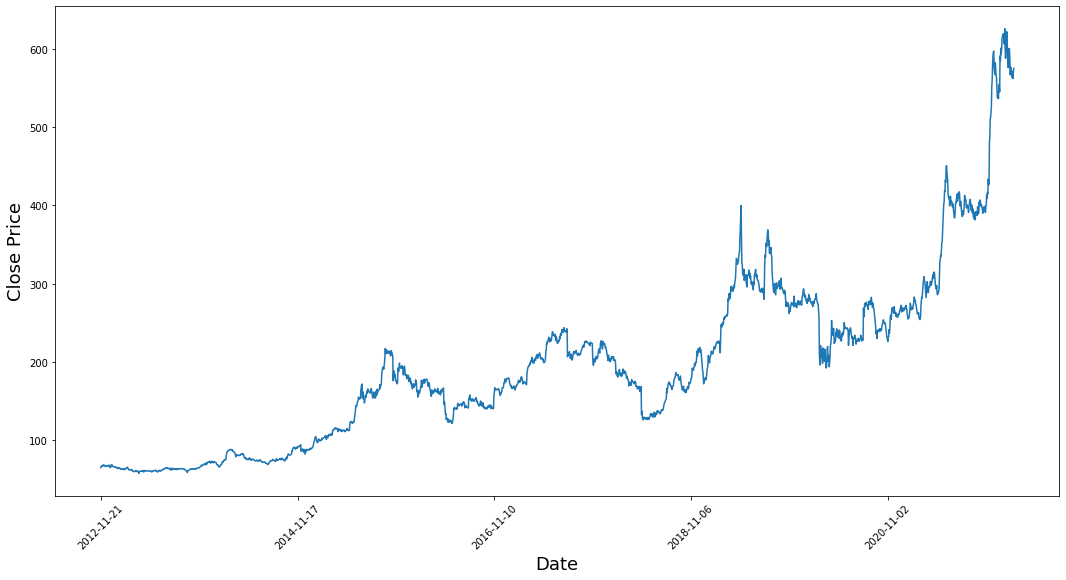

In [121]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]), df['Close'])
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price',fontsize=18)
plt.show()

In [122]:
midValue = int(df.iloc[:, 1].size/2)
training_set = df.iloc[:midValue, 4:5].values
test_set = df.iloc[midValue:, 4:5].values

print(midValue)
print(training_set.shape[0])
print(test_set.shape[0])

1160
1160
1161


In [123]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, midValue):
    X_train.append(training_set_scaled[i-40:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#(740, 60, 1)

In [124]:
X_train.shape

(1100, 40, 1)

In [125]:
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
35/35 [==============================] - 7s 38ms/step - loss: 0.0308
Epoch 2/100
35/35 [==============================] - 1s 36ms/step - loss: 0.0062
Epoch 3/100
35/35 [==============================] - 1s 36ms/step - loss: 0.0055
Epoch 4/100
35/35 [==============================] - 1s 38ms/step - loss: 0.0052
Epoch 5/100
35/35 [==============================] - 1s 36ms/step - loss: 0.0051
Epoch 6/100
35/35 [==============================] - 1s 36ms/step - loss: 0.0047
Epoch 7/100
35/35 [==============================] - 1s 40ms/step - loss: 0.0048
Epoch 8/100
35/35 [==============================] - 1s 38ms/step - loss: 0.0041
Epoch 9/100
35/35 [==============================] - 1s 39ms/step - loss: 0.0042
Epoch 10/100
35/35 [==============================] - 1s 40ms/step - loss: 0.0037
Epoch 11/100
35/35 [==============================] - 1s 40ms/step - loss: 0.0039
Epoch 12/100
35/35 [==============================] - 1s 40ms/step - loss: 0.0038
Epoch 13/100
35/35 [=====

In [126]:
# Getting the predicted stock price of 2017
dataset_train = df.iloc[:midValue, 4:5]
dataset_test = df.iloc[midValue:, 4:5]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 1000):
    X_test.append(inputs[i-40:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)
# (459, 60, 1)

(940, 40, 1)


In [127]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

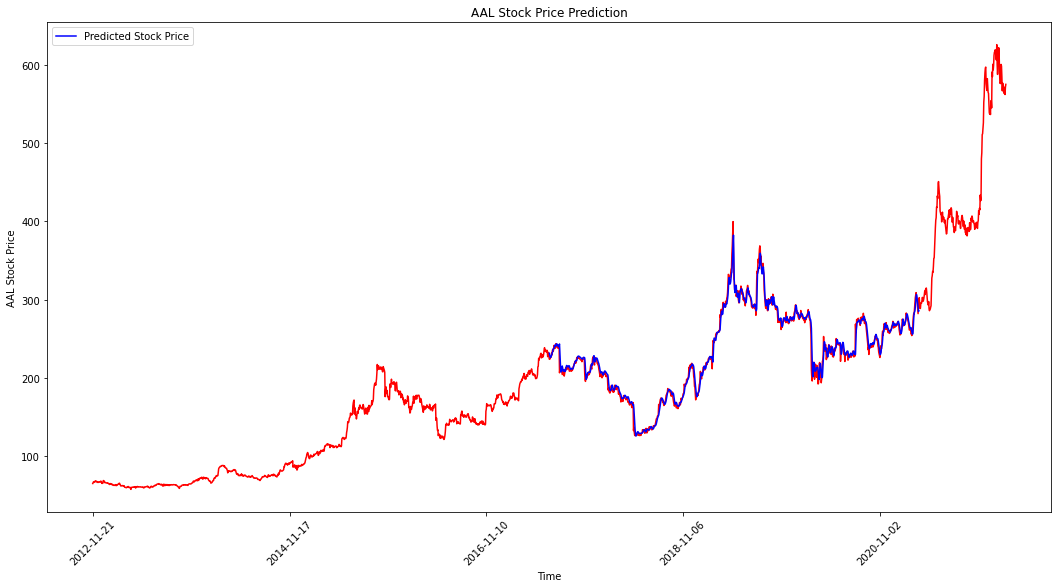

In [128]:
# Visualising the results
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]), df['Close'], color='red')
plt.plot(range(midValue,midValue+940),predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.title('AAL Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('AAL Stock Price')
plt.legend()
plt.show()
